# Prepare data

First we will create a dictionary of Semcor words, and look at them and their frequencies.

In [1]:
from nltk.corpus import semcor
from nltk.tree import Tree
import itertools
import random
import pandas as pd

In [2]:
"""
load semcor stats
"""

sents = semcor.tagged_sents( tag = ' sem ' )

words = semcor.words()



In [3]:
"""
load bert and model
"""

import torch
from bert import *

bert = BERTBase()

model = torch.load('ffnn.30eps.5k.training4418.saved')

INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /Users/gabriellachronis/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.modeling:extracting archive file /Users/gabriellachronis/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /var/folders/9m/vzvx58rs51v_x5nm620fz4xr0000gn/T/tmpt_i5d3lx
INFO:pytorch_pretrained_bert.modeling:Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 3

In [4]:
"""
create a dictionary of tokens in semcor with counts
"""
from collections import Counter

semcor_lexicon = Counter()

for word in words:
    semcor_lexicon[word] +=1

semcor_lexicon

Counter({'The': 5050,
         'Fulton': 14,
         'County': 66,
         'Grand': 15,
         'Jury': 3,
         'said': 1404,
         'Friday': 59,
         'an': 2508,
         'investigation': 32,
         'of': 24832,
         'Atlanta': 27,
         "'s": 4037,
         'recent': 115,
         'primary': 62,
         'election': 67,
         'produced': 62,
         '``': 6169,
         'no': 1267,
         'evidence': 131,
         "''": 6097,
         'that': 7212,
         'any': 925,
         'irregularities': 7,
         'took': 293,
         'place': 385,
         '.': 34716,
         'jury': 52,
         'further': 132,
         'in': 13771,
         'term': 52,
         'end': 262,
         'presentments': 1,
         'the': 44018,
         'City': 111,
         'Executive': 8,
         'Committee': 54,
         ',': 40614,
         'which': 2482,
         'had': 3510,
         'over-all': 19,
         'charge': 69,
         'deserves': 13,
         'praise': 12,
  

In [5]:
"""
get basic semcor stats
"""

print(len(sents))


# number of tokens
print(len(words))


# number of types
len(semcor_lexicon)

37176
820411


43416

Then, for each word, we find all of the tokens of that word in the corpus, and use the model to predict features for that word.



In [6]:
"""
first, index the sentences in the dataset
"""

semcor_indexer = Counter()

# just retrieve all the sentences
sents = semcor.sents()


for sent in sents:
    #print(sent.num)
    #print(sent)
    index = int(sent.num)
    semcor_indexer[index] = sent

"""
now we have an index of sentences, where the index corresponds to the n value in semcor, and the sentence is a list of string tokens
"""
print(semcor_indexer[32]) # ['The', 'petition', 'listed', 'the', 'mayor', "'s", 'occupation', 'as', '``', 'attorney', "''", 'and', 'his', 'age', 'as', '71', '.']

['Having', '(', 'through', 'my', 'unflagging', 'effort', 'and', 'devotion', ')', 'achieved', 'stardom', ',', 'a', 'fortune', 'and', 'a', 'world-renowned', 'wife', 'at', 'an', 'age', 'when', 'most', 'young', 'men', 'are', 'casting', 'their', 'first', 'vote', ',', 'Letch', 'proceeded', 'to', 'neglect', 'them', 'all', '.']


In [7]:
semcor_indexer

Counter({1: ['Needless',
          'to',
          'say',
          ',',
          'I',
          'was',
          'furious',
          'at',
          'this',
          'unparalleled',
          'intrusion',
          'upon',
          'free',
          'enterprise',
          '.'],
         2: ['How',
          'dared',
          'they',
          'demand',
          'to',
          '``',
          'snoop',
          "''",
          'in',
          'private',
          'financial',
          'records',
          ',',
          'disbursements',
          ',',
          'confidential',
          'contracts',
          'and',
          'agreements',
          '?'],
         3: ['``',
          'It',
          'is',
          'as',
          'though',
          "''",
          ',',
          'I',
          'said',
          'on',
          'the',
          'historic',
          'three-hour',
          ',',
          'coast-to-coast',
          'radio',
          'broadcast',
          'w

In [8]:
"""
Next step is to create an index of all of the tokens of a single word form. 
So, we build a data structure with all of the word forms found in semcor. With each word form,
we store a list of all of the sentences containing it.
"""
word_index = {}
sense_index = {}

# go through the dataset sentence by sentence
for sent in sents:
    sentence_id = int(sent.num)
    # go through each sentence word by word
    for word in sent:
        
    # we need to make sure we are collecting only those tokens which have semcor senses, or we make note of which ones do
    
        # if this is our first time seeing this word, add it to the index and put the sentence id in the entry
        if word not in word_index:
            word = word.lower()
            word_index[word] = {sentence_id}
        # otherwise, add the sentence id to the entry for the word
        else:
            word_index[word].add(sentence_id)
            

In [9]:
"""
let's take a look at it
"""
print(word_index)

{'the': {79, 80, 81, 84, 85, 89}, 'fulton': {27}, 'county': {129}, 'grand': {59}, 'jury': {66, 69, 70, 71, 42, 76, 77, 78, 81, 82, 21, 86, 55, 88, 28, 61}, 'said': {3, 4, 6, 9, 10, 12, 13, 14, 15, 17, 18, 20, 22, 23, 25, 28, 32, 33, 34, 36, 37, 39, 40, 42, 43, 44, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 91, 94, 96, 99, 100, 102, 103, 106, 108, 114, 116, 117, 118, 119, 122, 126, 127, 128, 131, 132, 133, 135, 138, 142, 145, 147, 150, 151, 153, 154, 155, 156, 157, 158, 160, 162, 164, 165, 166, 167, 199}, 'friday': {18}, 'an': {73, 79}, 'investigation': {70, 8, 72, 139, 12, 13, 48, 93, 55, 29, 30}, 'of': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 59, 60, 61, 62, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 

was
Pearsons correlation: -0.003, p-value: 0.9948439506144756
Spearmans correlation: 0.131, p-value: 0.8047261622231061


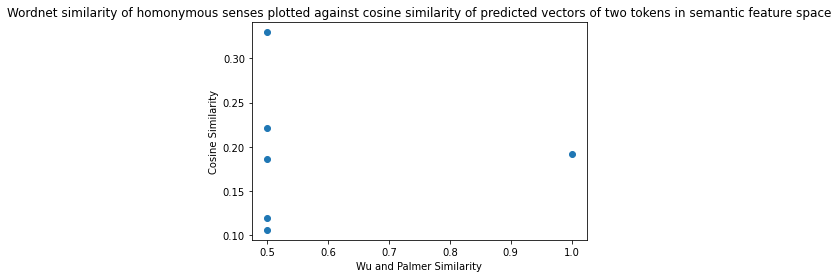

'\nWe have these values for a single word. we cant store them for the whole dataset because, \neven if we only have 1000 senses of a word,\n1000 choose 2 leaves us with almost 500K pairwise combinations of tokens.\n\n'

In [11]:
"""
Now what we need to do is go through each of the words and, 
using our model, predict the features in context for each of the tokens of that word.

We iterate through the stored sentenes containing that token.
- we find the word in the sentence, 
- we store its wordnet sense
- and we predict its features. 

"""
from nltk.corpus.reader import wordnet
from scipy.stats import spearmanr, pearsonr



tagged_sents = semcor.tagged_sents( tag = ' sem ' )


all_sense_similarities = []


for word, sentence_ids in word_index.items():
    wordform_data = []

#     print(word)
#     print(sentence_ids)
    for sentence_id in sentence_ids:
        sentence_string = ' '.join(semcor_indexer[sentence_id]).lower()
        
        # the list returned by nltk is indexed one behind the official id of the sentence in semcor
        tagged_sentence = tagged_sents[sentence_id - 1]
        #print(tagged_sentence)
        
        
        for chunk in tagged_sentence:

            chunk_string = ' '.join(chunk.leaves())
            
            """
            if we find the word we're looking for in this chunk,
            and that chunk has a wordnet sense (function words dont)
            then scoop it up

            """            
            if chunk_string.lower() == word:
                #print("found %s" % word)
                #print(chunk.label())

                #wn_lemma = cunk.label()
                if isinstance(chunk.label() , wordnet.Lemma):
                    try:
                        prediction = model.predict_in_context(word, sentence_string, bert)

                        row = {
                            "wordform": word,
                            "wn_lemma": chunk.label(),
                            "semcor_id": sentence_id,
                            "prediction": prediction,
                        }
                        wordform_data.append(row)
                    except:
                        None
        
        #print(row)
        #raise Exception('not done')
    
    
    """

    When we have all of these for a single wordform, we construct a dataset structured like this

        wn_lemma predicted_feature_vector

    First we should note how many senses there are, and how many tokens of each sense

    """
    df = pd.DataFrame.from_records(wordform_data, columns = ["wordform", "wn_lemma", "semcor_id", "prediction"])  
    #print(df)
    
    num_senses = df['wn_lemma'].value_counts()
    #print(counts)

    """

    then we calculate the pairwise distances between all of the vectors, only counting one pair one time

    """
    vals_for_this_token = []
    
    # pop the first token off the list
    num_toks = len(df)
    for i in range(0,num_toks):
        # compare it with each of the other tokens
        # dont have to compare to any earlier
        for j in range(i+1,num_toks):

            #print(df.iloc[i])
            #print(df.iloc[j])
            
            # calculate cosine similarity between the two vectors
            cos_sim = 1 - cosine(df.iloc[i].prediction, df.iloc[j].prediction)
            
            # and wu palmer similarity between the two wn lemmas
            synset1 = df.iloc[i].wn_lemma.synset()
            synset2 = df.iloc[j].wn_lemma.synset()
            wup_sim = synset1.wup_similarity(synset2)
            
            # if we can't compute a distance for these senses / recognize them, discard
            if type(wup_sim) == float:
                # store this data point into a list
                vals_for_this_token.append((cos_sim, wup_sim))
                all_sense_similarities.append((cos_sim, wup_sim))
    
    # store the values for this word into a dataframe
    
    sense_similarities = pd.DataFrame.from_records(vals_for_this_token, columns = ["cos_sim", "wup_sim"])
    # print(sense_similarities)
    
    
    if len(sense_similarities) > 1 :
        print(word)
        
        cos_sims = sense_similarities['cos_sim']
        wup_sims = sense_similarities['wup_sim']
    
        corr, p = pearsonr(cos_sims, wup_sims )
        print('Pearsons correlation: %.3f, p-value: %s'  % (corr, p))

        corr, p = spearmanr(cos_sims, wup_sims )
        print('Spearmans correlation: %.3f, p-value: %s'  % (corr, p))

        plt.scatter(wup_sims, cos_sims)
        plt.title("Wordnet similarity of homonymous senses plotted against cosine similarity of predicted vectors of two tokens in semantic feature space")
        plt.xlabel("Wu and Palmer Similarity")
        plt.ylabel("Cosine Similarity")
        plt.show()


        print()
        print()
        
"""
We have these values for a single word. we cant store them for the whole dataset because, 
even if we only have 1000 senses of a word,
1000 choose 2 leaves us with almost 500K pairwise combinations of tokens.

"""


In [ ]:
"""

some choices here: we are looking at correlations for multi-prototype model
including monosemous words
"""

all_sense_similarities = pd.DataFrame.from_records(all_sense_similarities, columns = ["cos_sim", "wup_sim"])

cos_sims = all_sense_similarities['cos_sim']
wup_sims = all_sense_similarities['wup_sim']

corr, p = pearsonr(cos_sims, wup_sims )
print('Pearsons correlation: %.3f, p-value: %s'  % (corr, p))

corr, p = spearmanr(cos_sims, wup_sims )
print('Spearmans correlation: %.3f, p-value: %s'  % (corr, p))

plt.scatter(wup_sims, cos_sims)
plt.title("Wordnet similarity of homonymous senses plotted against cosine similarity of predicted vectors of two tokens in semantic feature space")
plt.xlabel("Wu and Palmer Similarity")
plt.ylabel("Cosine Similarity")
plt.show()

In [ ]:

# multi_model_predictions = []



# def pluralize(string):
#     if string == 'mouse':
#         return 'mice'
#     else:
#         return string + 's'


    

# models = {"multi_prototype_model_preds": multi_model,
#          #"single_prototype_model_preds": single_model,
#          #"glove_model_preds": glove_model
#          }
# for label, model in models.items():
#     predictions = []        
    
#     for index, row in df.iterrows():
#         if index % 1000 == 0:
#             print("processed %s tokens" % index)
        
#         #print(df.semcor_token)
#         #print(row.sentence_id)
#         sentence = semcor_indexer.get_object(row.sentence_id)
#         #print(sentence)
#         #print(row.semcor_token)
#         prediction = model.predict_in_context(row.semcor_token, sentence, bert)
#         multi_model_predictions.append(prediction)
        
#         #singular = row.semcor_token
#         #plural = engine.plural(singular)

#         try:
#             predicted_vector = model.predict_in_context(row.semcor_token, sentence, bert)
#         except:
#             predicted_vector = model.predict_in_context(row.semcor_token, sentence, bert)


#         predictions.append(predicted_vector)

#     df[label] = predictions

# df
    
# df['multi_prototype_model_predictions'] = predictions

For each pair of tokens of the same lemma, we calculate
    (1) the distance between those two senses in wordnet
    (2) the cosine / jaqqard distance between the two predicted feature vectors.
and store these into a list, along with the lemma.

In [ ]:
"""
this is the stupid way that takes ten decades. why don;t you try this again but smarter in the next cell
"""


# wup_sims = []
# cossine_sims = []

# for index, row in df.iterrows():
#     wordform = row.semcor_token
    
#     # select other examples of this token
#     othertokens = df[df.semcor_token == wordform]
#     # filter out the token itself
#     othertokens = othertokens[othertokens.index != index]
#     #print(othertokens)
    
#     for index, otherword in othertokens.iterrows():
#         # find the wordnet distance between these two wordnet senses
#         synset1 = row.wn_lemma.synset()
#         synset2 = otherword.wn_lemma.synset()
        
#         wup_sim = synset1.wup_similarity(synset2)
#         wup_sims.append(wup_sim)
#         cossim = 1 - cosine(row.multi_prototype_model_preds, otherword.multi_prototype_model_preds)
#         #cossim = 1 - cosine(row.single_prototype_model_preds, otherword.single_prototype_model_preds)
#         cossine_sims.append(cossim)
#         #print(synset1)
#         #print(synset2)
#         #print(wup_sim)
#         #print(cossim)


In [ ]:
"""
same as above cell, but smarter. first we create a list of words in the corpus indexed to all the sentences containing that token.
"""



In [ ]:
# from math import isnan

# print(len(cossine_sims))
# print(len(wup_sims))

# for cs in cossine_sims:
#     if type(cs) != np.float64:
#         print(cs)
        
        
# # get rid of problematic nonetype rows for wu palmer similarity
# # in future I should figure out why they are problematic, giving none for similarity between lemmas


# zipped = list(zip(cossine_sims, wup_sims))
# new_cossine_sims = []
# new_wup_sims = []

# print(len(zipped))

# for index in range(0,len(zipped)):
#     if type(wup_sims[index]) == float:
#         new_cossine_sims.append(cossine_sims[index])
#         new_wup_sims.append(wup_sims[index])

Finally, we correlate the wordnet distance with the predicted features. 